#### In Second Part of Project we trained model to Classify image with single object
#### In Third part we employ model to Classify and count multiple objects on image

In [1]:
#  https://www.analyticsvidhya.com/blog/2021/08/beginners-guide-to-convolutional-neural-network-with-implementation-in-python/
# Upload libraries and Choose a CNN Architecture: 

import os
import numpy as np
import pandas as pd

import cv2
import sys
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import time

import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.models import load_model

## methods for accuracy check

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix # requires counts , integers , 1 or 0
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from random import sample


IMG_HEIGHT = 180
IMG_WIDTH = 180

In [2]:
def debug_photo( photo  ): # to visualise
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 3
    for i in range(1, columns*rows +1):
        loc = np.random.randint(1, len(photo),1 )
        img= photo[loc[0]]  # 1 class pictures , sampled randomly
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    

In [3]:
def preprocess_image( x, h=IMG_HEIGHT , w=IMG_WIDTH, pad_value=30, color_scheme=cv2.COLOR_BGR2RGB, inter_method=cv2.INTER_AREA ):
    
        timage = cv2.cvtColor(x, color_scheme) 
        
        timage = cv2.copyMakeBorder(timage, pad_value, pad_value, pad_value, pad_value, 
                                           cv2.BORDER_CONSTANT, None, value=[255, 255, 255] ) 
        
        timage=cv2.resize(timage, (h, w), # make all pictures standard
                                 interpolation = inter_method)
        
        return timage
    

In [4]:
def accuracy_metrics(model ,  x_test , y_test , loop_count, sample_size ):

        for i in range(0,loop_count):

                loc = np.random.choice( x_test.shape[0], size = int( sample_size*x_test.shape[0]  ), replace=False, p=None)
                x_test_sample = x_test[loc]
                y_test_sample = y_test[loc]
                out = model.predict(x_test_sample)
                out_classes = ( out >= 0.7 ) + 0 # to whole numbers 

                ac_metrics = {
                    "accuracy": [accuracy_score( y_test_sample , out_classes )], 
                    "precision":[precision_score( y_test_sample , out_classes, zero_division=0) ], 
                    "recall":[recall_score( y_test_sample , out_classes )]
                             }

                out_table = pd.DataFrame(ac_metrics,  index=[i])

                if i==0:   
                    result = out_table
                else:
                    result = pd.concat([result, out_table])
                    
        return result  

In [5]:

## load model, pixel classification

model_v0_rgb_detect = load_model(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v0_rgb_detect.keras")

model_v0_rgb_detect.summary()     


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [6]:
# upload test images with multiple objects

data_location = r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\Test_Object_Detection_Synthetic\Augmented_3"

img_data_multiple_objects=[] 
img_data_multiple_objects_count=[] 

img_data_multiple_objects_proc=[] 
img_data_multiple_objects_count_proc=[] 


for dir1 in os.listdir(data_location): # loop through folder in main directory
    
        image_path= os.path.join(data_location, dir1) # full path to file we need to upload
        image= cv2.imread( image_path, cv2.IMREAD_COLOR) # import pixels of picture, colored , 3 dimensions
        image = preprocess_image(x = image, h=500, w=500, pad_value=0)
        
        target_count = dir1.split("_")[1]

        if dir1.split("_")[3]=="proc" : # we skip forest_train_test, used later 
                         
                img_data_multiple_objects_proc.append(image) # append each picture to single structure   
                img_data_multiple_objects_count_proc.append(int(target_count) ) 
                
        else: # pictures which belong to non apples ( other consumables , tasty and healthy )

                img_data_multiple_objects.append(image) # append each picture to single structure   
                img_data_multiple_objects_count.append(int(target_count) )   

   

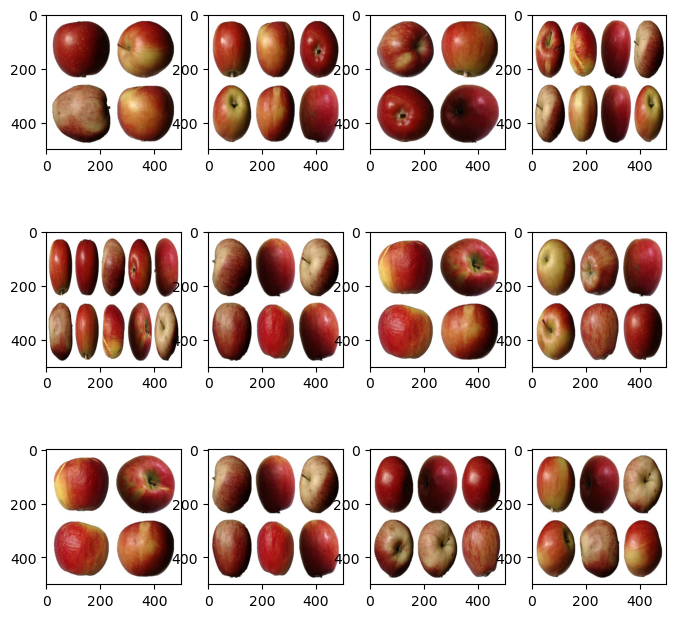

In [7]:
debug_photo( photo=img_data_multiple_objects )     

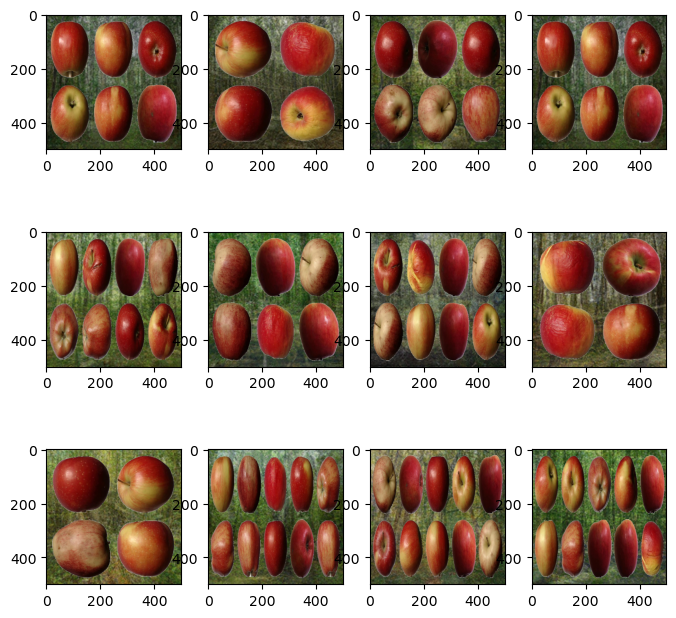

In [8]:
debug_photo( photo=img_data_multiple_objects_proc ) 

In [7]:
## function to generate proposals ( boxes, sub pics , anchors, rects, rectangles  ) of 
## single  picture, in generates 4 coordinates( x, y, x+w, y+h ) of segment inside picture(green rectangles )
## More diverse picture is in terms of pixels values, more contrasts it has and therefore, 
## more possible objects and therefore, more proposals

def generate_proposals( timage ):
 
        ss_buf = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # We initiate classes which implement R CNN in python
    
        ss_buf.setBaseImage( timage ) # we  define image we want to breake into smaller pics
        
        ss_buf.switchToSelectiveSearchQuality() 
          # we initiate approach to breake the main picture
             #  switchToSelectiveSearchQuality , switchToSelectiveSearchFast (smaller number of picts)

        ssresults_buf = ss_buf.process()  # we generate coordidates of sub pics 

        return ssresults_buf # return coordinates
    

In [25]:
# function  to predict with CNN if proposals generated
# by generate_proposals() has 0 or 1-st class

def predict_proposal( x , model , rects  , lower_lim = 0, upper_lim=0.2, reacts_lim = 2500 ):
   
    imout = x.copy() # reset image to clean it from rectangles
    gray = cv2.cvtColor(imout, cv2.COLOR_BGR2GRAY) 

    for count ,result in enumerate(rects): 
        if count <= reacts_lim:
                x,y,w,h = result
                timage = gray[y:y+h,x:x+w] # this is sub pic, proposal, rect cut from main image
                resized = cv2.resize(timage, ( IMG_WIDTH,IMG_HEIGHT ), interpolation = cv2.INTER_AREA)
                resized = np.array( resized, dtype = "float16" )
                resized /= 255 
                img = np.expand_dims(resized, axis=0)
                
                out= model.predict(img, verbose = 0) # verbose of 1 will produce message for each proposal, not convenient
                
                if out[0][0] >= lower_lim and out[0][0] <= upper_lim : # based on probability we define if 1 or 0 is predicted class
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)                 
    return imout  


In [9]:
## function to count objects without CNN

def count_contour( x ,  blur_kernel=(11,11) , canny_bottom=50, canny_top=150 ) :

    gray  = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
      # increase chances of detecting contour
    blur = cv2.GaussianBlur(gray, blur_kernel , 0)
      # reduces noice and smooths coutour lines
    edge = cv2.Canny(blur, canny_bottom, canny_top)
      # estimates countour
    dilated = cv2.dilate(edge, (2, 2), iterations=2)
      # thickens contour lines

    (cnt, hierarchy) = cv2.findContours(
                                dilated.copy(),   
                                cv2.RETR_EXTERNAL, # only largest contours
                                cv2.CHAIN_APPROX_NONE)
    rgb = x.copy()

    cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)
  
    return rgb , len( cnt )


#### Solution v0 based on findContours

#### Highlight Red Color and dim background based on quantiles on Red Colors

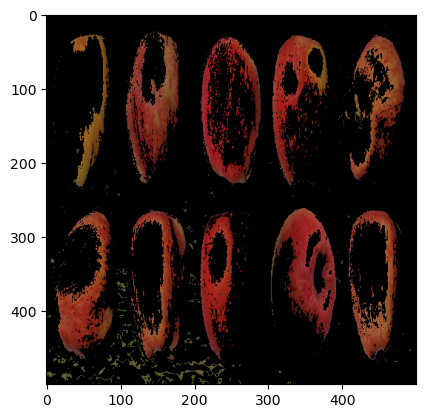

In [258]:
##### Example , manupulate background

#### Keep pixels which highlight red colour
#### Use logical filtering over pixels values

## Method 0

image_1  = img_data_multiple_objects_proc[1]
red_apples = image_1.copy()

# red_filtered = (red_apples[:,:,0] > 80) & (red_apples[:,:,1] < 100) & (red_apples[:,:,2] < 255)
red_filtered = (red_apples[:,:,0] >=90 ) & (red_apples[:,:,0] <= 174)  & (red_apples[:,:,1] >=22) & (red_apples[:,:,1] <= 101) & (red_apples[:,:,2] >= 15) & (red_apples[:,:,2] <= 64) 

# ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

red_apples_new = image_1.copy()
red_apples_new[:, :, 0] = red_apples_new[:, :, 0] * red_filtered
red_apples_new[:, :, 1] = red_apples_new[:, :, 1] * red_filtered
red_apples_new[:, :, 2] = red_apples_new[:, :, 2] * red_filtered

plt.imshow(red_apples_new);
# http://www.workwithcolor.com/red-color-hue-range-01.htm

#### Apply NN to predict if pixel belongs to Apple RGB

39


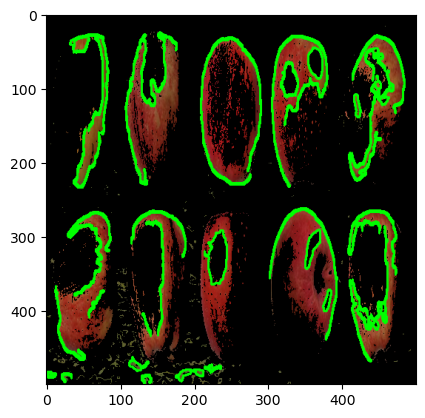

In [259]:
plot_object , count_apples = count_contour ( x=red_apples_new )
print( count_apples )
plt.imshow( plot_object )

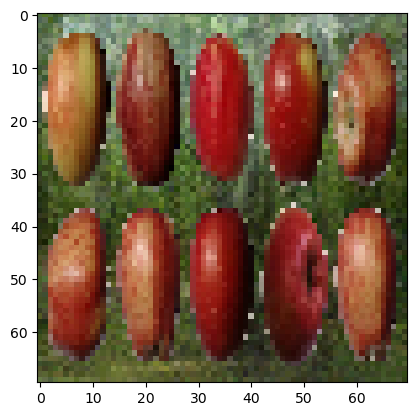

In [260]:
### Classify each Pixel, assign 0 if it considered as non apple
image_proto =  cv2.resize(image_1, (70, 70), # make all pictures standard
                                 interpolation = cv2.INTER_CUBIC)
 
plt.imshow( image_proto )

In [10]:
### Upload mapping table generated in Block 3 in first part of project

df_mapping_rgb = pd.read_csv( r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\rgb_mapping.txt" )
df_mapping_rgb.head(5)


,R,G,B,class_val,rgb_profile
0,51,10,7,1,51_10_7
1,51,10,8,1,51_10_8
2,51,10,9,1,51_10_9
3,51,10,10,1,51_10_10
4,51,10,11,1,51_10_11


In [11]:
df_mapping_rgb.dtypes # debug

R               int64
G               int64
B               int64
class_val       int64
rgb_profile    object
dtype: object

In [11]:
######## select pixels which belong to apples

df_mapping_rgb_target = df_mapping_rgb[df_mapping_rgb["class_val"]==1 ]
df_mapping_rgb_target.reset_index(inplace=True) # to avoid key error
df_mapping_rgb_target["class_val"].unique()


array([1], dtype=int64)

In [264]:
df_mapping_rgb_target.head(5)

,index,R,G,B,class_val,rgb_profile
0,0,51,10,7,1,51_10_7
1,1,51,10,8,1,51_10_8
2,2,51,10,9,1,51_10_9
3,3,51,10,10,1,51_10_10
4,4,51,10,11,1,51_10_11


In [12]:
#### List to Dictionary with values mapping
#### Checking if element is in a dictionary keys is faster compare to checking if element
#### is contained in list

# https://towardsdatascience.com/faster-lookups-in-python-1d7503e9cd38

start = time.time()

res = { df_mapping_rgb_target["rgb_profile"][i]:df_mapping_rgb_target["class_val"][i]  for i in range( 0, df_mapping_rgb_target.shape[0] ) }

print( round(time.time() - start,2) // 60 )


0.0


0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
8.0 min


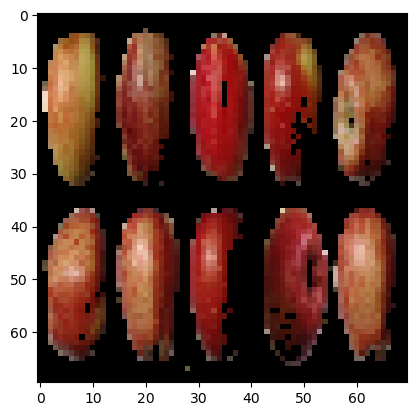

In [22]:
## Demo to count objects on picture with background 
## classifying each pixel on fly

## Method 1
### uint8 vs float16 produce same result

### Running time 8 min per photo of 70*70 including prelim filtering 
start = time.time()

denom = 70 ** 2
image_proto =  cv2.resize(image_1, (70, 70),  interpolation = cv2.INTER_CUBIC)

ct = 0 
for i2 in range(0 , image_proto.shape[0] ):
    
                if int( ( (ct/denom ) *100 ) ) % 10 == 0 :
                            print( ct/denom ) # print( ct / ( denom ) )
        
                for j2 in range(0 , image_proto.shape[0]  ):
                    ct+=1          
                    buf = image_proto[ i2 , j2 , :].reshape( 1,-1 )   # data of uint8 type     
                                     
                    if np.all( buf > 230 )  or  ( buf[0][0]<51 or buf[0][1]<10 or  buf[0][2]<7 ) : 
                        image_proto[ i2 , j2 , :] = np.zeros(3)
                            
                    else:    # forecast is the longest part, we skip it if pizel for red is out of range
                
                        x_test_transform = np.array( buf, dtype="float16" )
                        x_test_transform /= 255 

                        out = model_v0_rgb_detect.predict( x_test_transform, verbose = 0 )

                        if ( out[0][0]<=0.2 ):
                            image_proto[ i2 , j2 , :] = np.zeros(3)        

print( str(round(time.time() - start,2) // 60) + " min" )

plt.imshow( image_proto )   


12


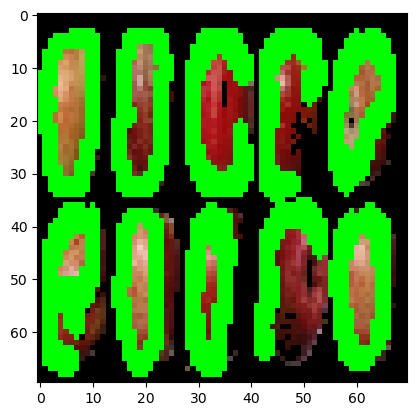

In [23]:
##### count objects
plot_object , count_apples = count_contour ( x=image_proto )
print( count_apples )
plt.imshow( plot_object )

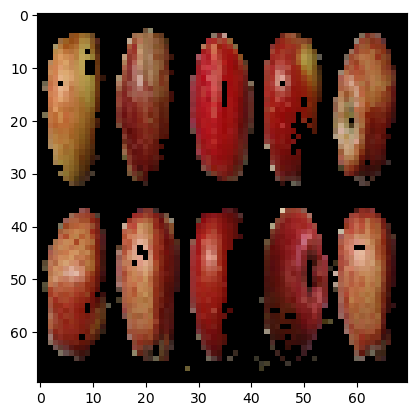

In [21]:
## Demo to count objects on picture with background 
## using RGB mapping

## Method 2

## instant solution

image_proto =  cv2.resize(image_1, (70, 70),  interpolation = cv2.INTER_CUBIC)

ct = 1 
for i2 in range(0 , image_proto.shape[0] ):
                #print( ct / ( image_proto.shape[0] * image_proto.shape[0] ) )
                for j2 in range(0 , image_proto.shape[0]  ):
                    ct+=1          
                    buf = image_proto[ i2 , j2 , :].reshape( 1,-1 ).astype("uint8") # to parse string properly     
                    
                   # if np.all( buf > 230 )  or  ( buf[0][0]<51 or buf[0][1]<10 or  buf[0][2]<7 ) : 
                   #     image_proto[ i2 , j2 , :] = np.zeros(3) 
                   
                   # else:
                        
                   # generate dictionary key
                    buf = buf.tolist()[0] # nested list with floats
                   # buf = [ int(x) for x in buf ]  # flatten list of integers
                    test_string  = str(buf[0]) + "_" + str(buf[1])  + "_" + str(buf[2] ) # concatenate key                                     

                    if ( test_string not in res.keys() ):
                            image_proto[ i2 , j2 , :] = np.zeros(3)
                
                
plt.imshow( image_proto )   

10


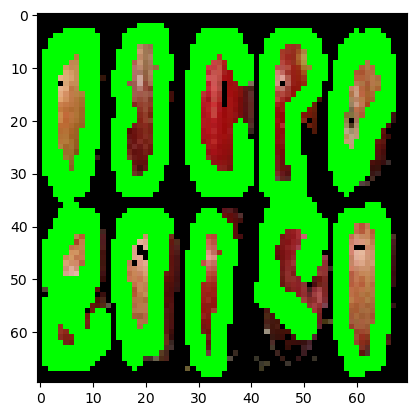

In [22]:
#####
plot_object , count_apples = count_contour ( x=image_proto )
print( count_apples )
plt.imshow( plot_object )

In [23]:
#### Apply count_contour function over all uploaded photos with no background

prediction_findContours_no_background = []

for i in img_data_multiple_objects:
    
    plot_object , count_apples = count_contour ( x=i,   blur_kernel=(11,11) , canny_bottom=50, canny_top=150 )
    prediction_findContours_no_background.append( count_apples )
   # plt.figure()
   # plt.imshow( plot_object )
    

In [24]:
[ img_data_multiple_objects_count , prediction_findContours_no_background ]

[[10, 10, 10, 10, 10, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8],
 [12, 11, 10, 10, 12, 4, 4, 5, 4, 6, 6, 6, 6, 7, 6, 8, 8, 8, 8, 8]]

{'r2_score': [0.8369565217391304], 'MAPE': [0.0625]}


<AxesSubplot:>

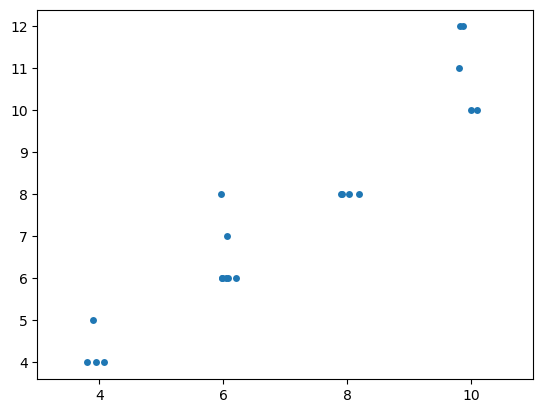

In [25]:
print( {     
         "r2_score": [r2_score( img_data_multiple_objects_count , prediction_findContours_no_background, )] ,
         "MAPE": [mean_absolute_percentage_error( img_data_multiple_objects_count , prediction_findContours_no_background, )]
       } )

sns.stripplot( x=img_data_multiple_objects_count , y =prediction_findContours_no_background  )
  # sns.scatterplot

In [26]:
# count_contour for pics with background without pixel blackening
prediction_findContours_w_background = []

for i in img_data_multiple_objects_proc:
    
    plot_object , count_apples =  count_contour ( x=i,   blur_kernel=(13,13) , canny_bottom=60, canny_top=150 )
    prediction_findContours_w_background.append( count_apples )
  #  plt.figure()
  #  plt.imshow( plot_object )


{'r2_score': [-3.891304347826087], 'MAPE': [0.6920833333333334]}


<AxesSubplot:>

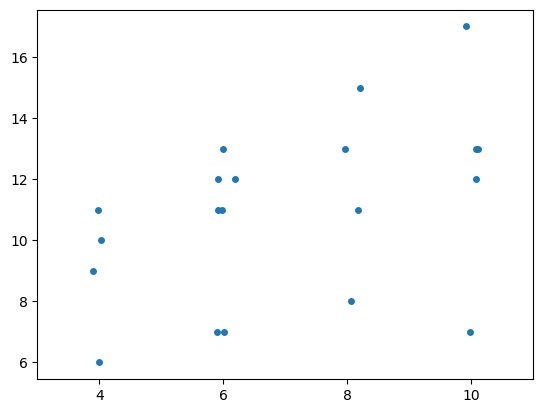

In [27]:
print( { 
    "r2_score": [r2_score( img_data_multiple_objects_count_proc , prediction_findContours_w_background, )] ,
    "MAPE": [mean_absolute_percentage_error( img_data_multiple_objects_count_proc , prediction_findContours_w_background, )] 
    }      
     )

sns.stripplot( x=img_data_multiple_objects_count_proc , y =prediction_findContours_w_background  )

In [61]:
# count_contour for pics with background with pixel blackening
# based on Method 2, mapping

image_pixel_classified = []
denom = 70 ** 2

start = time.time()

for image_proto in img_data_multiple_objects_proc:
    
        image_proto =  cv2.resize(image_proto, (70, 70), # make all pictures standard
                                 interpolation = cv2.INTER_CUBIC)

        ct = 0 
        for i2 in range(0 , image_proto.shape[0] ):
                      #  if int( ( (ct/denom ) *100 ) ) % 10 == 0 :
                      #       print( ct/denom ) # print( ct / ( denom ) )
                
                        for j2 in range(0 , image_proto.shape[0]  ):
                            ct+=1          
                            buf = image_proto[ i2 , j2 , :].reshape( 1,-1 ).astype("uint8") # to parse string properly  
                            
                            if np.all( buf > 230 )  or  ( buf[0][0]<51 or buf[0][1]<10 or  buf[0][2]<7 ) : 
                                image_proto[ i2 , j2 , :] = np.zeros(3) 
                   
                            else:
                        
                                buf = buf.tolist()[0] # nested list with floats
                                test_string  = str(buf[0]) + "_" + str(buf[1])  + "_" + str(buf[2] ) # concatenate key                                     

                                if ( test_string not in res.keys() ):
                                        image_proto[ i2 , j2 , :] = np.zeros(3)

        image_pixel_classified.append( image_proto )
        
print( str(round(time.time() - start,2) // 60) + " min" )      

0.0 min


In [68]:
prediction_findContours_w_background = []
plt.rcParams.update({'figure.max_open_warning': 50})

for i in image_pixel_classified:
    
    plot_object , count_apples =  count_contour ( x=i,   blur_kernel=(13,13) , canny_bottom=60, canny_top=150 ) # requies adjustment
    prediction_findContours_w_background.append( count_apples )
  #  plt.figure()
  #  plt.imshow( plot_object )

In [37]:
[ img_data_multiple_objects_count_proc , prediction_findContours_w_background ] 

[[10, 10, 10, 10, 10, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8],
 [9, 9, 13, 10, 9, 5, 4, 4, 4, 3, 7, 6, 6, 7, 6, 6, 8, 9, 7, 8]]

{'r2_score': [0.7173913043478262], 'MAPE': [0.09666666666666665]}


<AxesSubplot:>

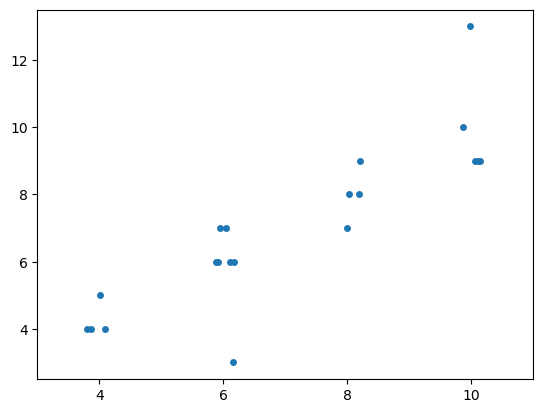

In [69]:
print( {
    "r2_score": [r2_score( img_data_multiple_objects_count_proc , prediction_findContours_w_background )] ,
    "MAPE": [mean_absolute_percentage_error( img_data_multiple_objects_count_proc , prediction_findContours_w_background )] 
 } )
sns.stripplot( x=img_data_multiple_objects_count_proc , y =prediction_findContours_w_background  )

In [39]:
# count_contour for pics with background with pixel blackening
# based on Method 1, predict class

image_pixel_classified = []
denom = 70 ** 2

start = time.time()
#! 10 photos 70*70 are processed  in 88 min
# 20 photos 70*70 in 176

for image_proto in img_data_multiple_objects_proc:
    
        image_proto =  cv2.resize(image_proto, (70, 70), # make all pictures standard
                                 interpolation = cv2.INTER_CUBIC)

        ct = 1 
        for i2 in range(0 , image_proto.shape[0] ):
                        if int( ( (ct/denom ) *100 ) ) % 10 == 0 :
                             print( [ct/denom] ) # print( ct / ( denom ) )
                
                        for j2 in range(0 , image_proto.shape[0]  ):
                            ct+=1          
                            buf = image_proto[ i2 , j2 , :].reshape( 1,-1 )                             
                        
                            if np.all( buf > 230 )  or  ( buf[0][0]<51 or buf[0][1]<10 or  buf[0][2]<7 ) : 
                                  image_proto[ i2 , j2 , :] = np.zeros(3)                                
                                                        
                            else:    # forecast is the longest part, we skip it if pizel for red is out of range
                
                                  x_test_transform = np.array( buf, dtype="float16" )
                                  x_test_transform /= 255 

                                  out = model_v0_rgb_detect.predict( x_test_transform, verbose = 0 )

                                  if ( out[0][0]<=0.2 ):
                                       image_proto[ i2 , j2 , :] = np.zeros(3) 
                                        
        image_pixel_classified.append( image_proto )

print( str(round(time.time() - start,2) // 60) + " min" )      


[0.00020408163265306123]
[0.10020408163265306]
[0.20020408163265307]
[0.30020408163265305]
[0.4002040816326531]
[0.5002040816326531]
[0.600204081632653]
[0.700204081632653]
[0.8002040816326531]
[0.9002040816326531]
[0.00020408163265306123]
[0.10020408163265306]
[0.20020408163265307]
[0.30020408163265305]
[0.4002040816326531]
[0.5002040816326531]
[0.600204081632653]
[0.700204081632653]
[0.8002040816326531]
[0.9002040816326531]
[0.00020408163265306123]
[0.10020408163265306]
[0.20020408163265307]
[0.30020408163265305]
[0.4002040816326531]
[0.5002040816326531]
[0.600204081632653]
[0.700204081632653]
[0.8002040816326531]
[0.9002040816326531]
[0.00020408163265306123]
[0.10020408163265306]
[0.20020408163265307]
[0.30020408163265305]
[0.4002040816326531]
[0.5002040816326531]
[0.600204081632653]
[0.700204081632653]
[0.8002040816326531]
[0.9002040816326531]
[0.00020408163265306123]
[0.10020408163265306]
[0.20020408163265307]
[0.30020408163265305]
[0.4002040816326531]
[0.5002040816326531]
[0.6002

In [58]:
prediction_findContours_w_background = []

for i in image_pixel_classified:
    
    plot_object , count_apples =  count_contour ( x=i,   blur_kernel=(13,13) , canny_bottom=0, canny_top=150 )
    prediction_findContours_w_background.append( count_apples )
  #  plt.figure()
  #  plt.imshow( plot_object )

In [59]:
[ img_data_multiple_objects_count_proc , prediction_findContours_w_background ] 

[[10, 10, 10, 10, 10, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8],
 [9, 10, 11, 9, 8, 4, 4, 3, 4, 5, 7, 7, 6, 6, 6, 6, 9, 9, 8, 10]]

{'r2_score': [0.8152173913043479], 'MAPE': [0.0875]}


<AxesSubplot:>

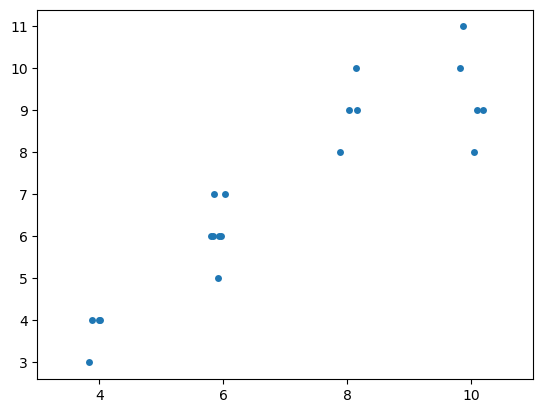

In [60]:
print( { 
    "r2_score": [r2_score( img_data_multiple_objects_count_proc , prediction_findContours_w_background )] ,
    "MAPE": [mean_absolute_percentage_error( img_data_multiple_objects_count_proc , prediction_findContours_w_background )] 
} )

sns.stripplot( x=img_data_multiple_objects_count_proc , y =prediction_findContours_w_background  )

In [14]:
gc.collect()

0

In [15]:
# count_contour for pics with background with pixel blackening
# based on Method 3, predict class with dynamic mapping

image_pixel_classified = []
stored_0_class_pred_map = {"dummy":0}
denom = 70 ** 2 # larger dim indicates more pixels which in turns means more identical values
count_classified = 0

#! 10 photos 70*70 are processed  in 82.0 min
# 20 photos 70*70 in 167.0 min

start = time.time()

for image_proto in img_data_multiple_objects_proc:
    
        image_proto =  cv2.resize(image_proto, (70, 70), # make all pictures standard
                                 interpolation = cv2.INTER_CUBIC)

        ct = 0 
        count_classified = 0
        
        for i2 in range(0 , image_proto.shape[0] ):
            
                        if int( ( (ct/denom ) *100 ) ) % 10 == 0 :
                             print( [ ct/denom, count_classified ]  ) # print( ct / ( denom ) )
                                              
                        for j2 in range(0 , image_proto.shape[0]  ):
                            ct+=1          
                            buf = image_proto[ i2 , j2 , :].reshape( 1,-1 ).astype("uint8")     
                            
                            buf_temp = buf.tolist()[0] # nested list with floats                          
                            test_string  = str(buf_temp[0]) + "_" + str(buf_temp[1])  + "_" + str(buf_temp[2] ) # concatenate key   
                            
                            if test_string in stored_0_class_pred_map.keys():
                                
                                    count_classified+=1
                                    image_proto[ i2 , j2 , :] = np.zeros(3)
                                                        
                            elif np.all( buf > 230 )  or  ( buf[0][0]<51 or buf[0][1]<10 or  buf[0][2]<7 ) : 
                                
                                    image_proto[ i2 , j2 , :] = np.zeros(3)                                   
                                    stored_0_class_pred_map[test_string] = 0
                            
                            else:    # forecast is the longest part, we skip it if pizel for red is out of range
                
                                  x_test_transform = np.array( buf, dtype="float16" )
                                  x_test_transform /= 255 

                                  out = model_v0_rgb_detect.predict( x_test_transform, verbose = 0 )

                                  if ( out[0][0]<=0.2 ):
                                    
                                        image_proto[ i2 , j2 , :] = np.zeros(3)                                       
                                        stored_0_class_pred_map[test_string] = 0

        image_pixel_classified.append( image_proto )
 
print( str(round(time.time() - start,2) // 60) + " min" )      



[0.0, 0]
[0.1, 0]
[0.2, 3]
[0.3, 6]
[0.4, 12]
[0.5, 16]
[0.6, 23]
[0.7, 30]
[0.8, 36]
[0.9, 40]
[0.0, 0]
[0.1, 3]
[0.2, 8]
[0.3, 14]
[0.4, 19]
[0.5, 30]
[0.6, 43]
[0.7, 47]
[0.8, 52]
[0.9, 63]
[0.0, 0]
[0.1, 6]
[0.2, 15]
[0.3, 20]
[0.4, 42]
[0.5, 60]
[0.6, 69]
[0.7, 75]
[0.8, 80]
[0.9, 95]
[0.0, 0]
[0.1, 7]
[0.2, 10]
[0.3, 16]
[0.4, 33]
[0.5, 49]
[0.6, 69]
[0.7, 77]
[0.8, 108]
[0.9, 154]
[0.0, 0]
[0.1, 25]
[0.2, 42]
[0.3, 68]
[0.4, 88]
[0.5, 109]
[0.6, 130]
[0.7, 140]
[0.8, 153]
[0.9, 180]
[0.0, 0]
[0.1, 15]
[0.2, 43]
[0.3, 79]
[0.4, 129]
[0.5, 159]
[0.6, 185]
[0.7, 205]
[0.8, 220]
[0.9, 249]
[0.0, 0]
[0.1, 29]
[0.2, 43]
[0.3, 55]
[0.4, 74]
[0.5, 112]
[0.6, 157]
[0.7, 190]
[0.8, 233]
[0.9, 297]
[0.0, 0]
[0.1, 13]
[0.2, 24]
[0.3, 38]
[0.4, 51]
[0.5, 74]
[0.6, 97]
[0.7, 130]
[0.8, 162]
[0.9, 230]
[0.0, 0]
[0.1, 45]
[0.2, 65]
[0.3, 83]
[0.4, 99]
[0.5, 154]
[0.6, 190]
[0.7, 218]
[0.8, 250]
[0.9, 294]
[0.0, 0]
[0.1, 17]
[0.2, 26]
[0.3, 46]
[0.4, 82]
[0.5, 152]
[0.6, 195]
[0.7, 215]
[0.8, 22

In [32]:
prediction_findContours_w_background = []

for i in image_pixel_classified:
    
    plot_object , count_apples =  count_contour ( x=i,   blur_kernel=(13,13) , canny_bottom=0, canny_top=150 )
    prediction_findContours_w_background.append( count_apples )
  #  plt.figure()
  #  plt.imshow( plot_object )

In [33]:
[ img_data_multiple_objects_count_proc , prediction_findContours_w_background ] 

[[10, 10, 10, 10, 10, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8],
 [9, 10, 11, 9, 8, 4, 4, 3, 4, 5, 7, 7, 6, 6, 6, 6, 9, 9, 8, 10]]

{'r2_score': [0.8152173913043479], 'MAPE': [0.0875]}


<AxesSubplot:>

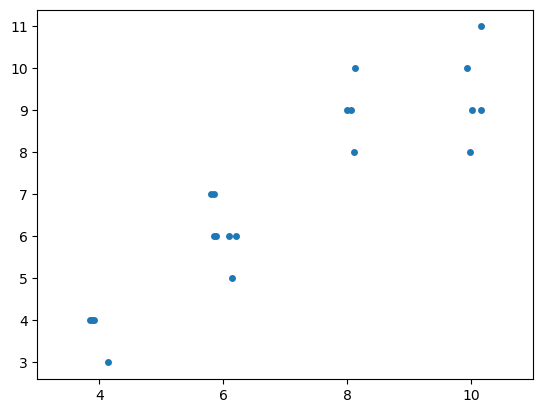

In [34]:
print( {
    "r2_score": [r2_score( img_data_multiple_objects_count_proc , prediction_findContours_w_background )] ,
    "MAPE": [mean_absolute_percentage_error( img_data_multiple_objects_count_proc , prediction_findContours_w_background )] 
} )
sns.stripplot( x=img_data_multiple_objects_count_proc , y =prediction_findContours_w_background  )

#### Proceed with Selective Search

In [13]:
# uplaad model trained in second part

model_v0_cnn_binary = load_model(r"D:\0_Desctop_Files\Learning\UTM_Project\1_Prototype\model_v0_cnn_binary.keras")
        # model below is train with max of 64 filters which detects better than complications close to Vgg16
        # 1*16 , 1*32, 1*64 , flat , 128
 

In [14]:
image_1  = img_data_multiple_objects_proc[1] # (500, 500, 3)

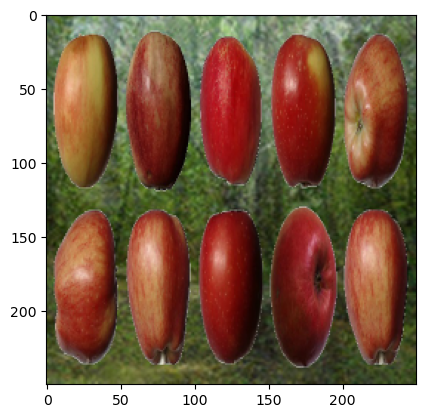

In [16]:
image_1_resized =cv2.resize(image_1, (250, 250), # make all pictures standard
                                 interpolation = cv2.INTER_AREA)
plt.imshow(image_1_resized)

In [17]:
# generate coordinates of proposals( sub pics )

ssresults1 = generate_proposals( timage = image_1_resized )
len(ssresults1) # number of pics generated, 
               # value depends on pixels density

1562

In [18]:
ssresults1 ### coordinates of rectangle

array([[ 92,  17,  54,  97],
       [ 58,  92,  16,  27],
       [ 46,  40,   7,  49],
       ...,
       [ 17,   0, 233, 239],
       [  0,   0, 196, 250],
       [  0,   0, 106, 158]])

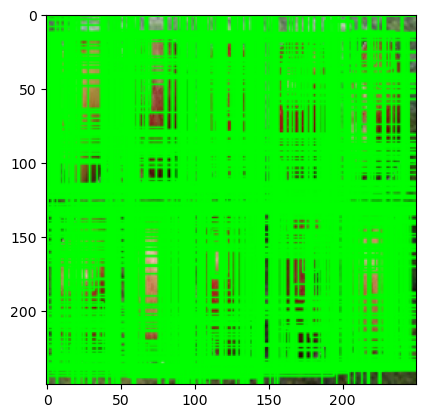

In [19]:
############ Check number of proposals for original picture

imout = image_1_resized.copy()

for count ,result in enumerate(ssresults1): 
     # if count <=2500:
                x,y,w,h = result
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                     # code above draws rectangles on main picture
plt.figure()
plt.imshow(imout)


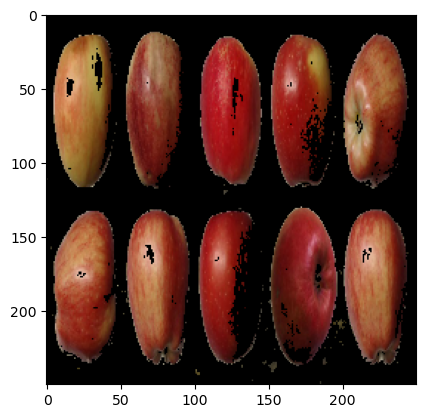

In [26]:
## Blacken background with mapping

image_1_blackened =  image_1_resized.copy()
## shuld be same size as original photo
ct = 1 
for i2 in range(0 , image_1_blackened.shape[0] ):
                for j2 in range(0 , image_1_blackened.shape[0]  ):
                    ct+=1          
                    buf = image_1_blackened[ i2 , j2 , :].reshape( 1,-1 ).astype("uint8") # to parse string properly      
                    buf = buf.tolist()[0] # nested list with floats

                    test_string  = str(buf[0]) + "_" + str(buf[1])  + "_" + str(buf[2] ) # concatenate key                                     

                    if ( test_string not in res.keys() ):
                            image_1_blackened[ i2 , j2 , :] = np.zeros(3)              
plt.imshow( image_1_blackened )   


In [27]:
# check proposals after blackening

ssresults1 = generate_proposals( timage = image_1_blackened )
len(ssresults1) # number of pics generated, 
               # value depends on pixels density

1368

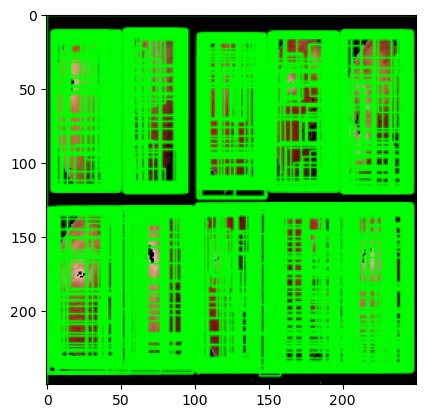

In [28]:
############ Check number of proposals for processed image

imout = image_1_blackened.copy()

for count ,result in enumerate(ssresults1): 
     # if count <=2500:
                x,y,w,h = result
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                     # code above draws rectangles on main picture
plt.figure()
plt.imshow(imout)

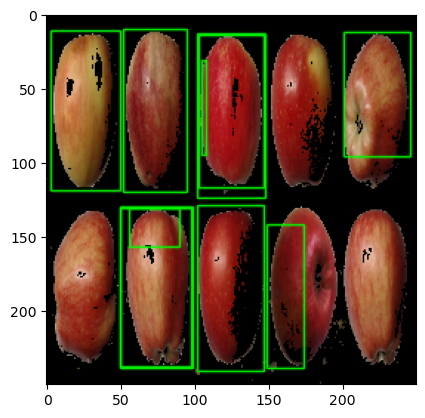

In [29]:
### predict class 1 for processed image

plt.figure()
plt.imshow(  predict_proposal( image_1_blackened , model=model_v0_cnn_binary  , rects = ssresults1 , lower_lim = 0.5, upper_lim=1, reacts_lim = 100 )  )
  

####  IoU Demonstration
#### Before incorporating into loop

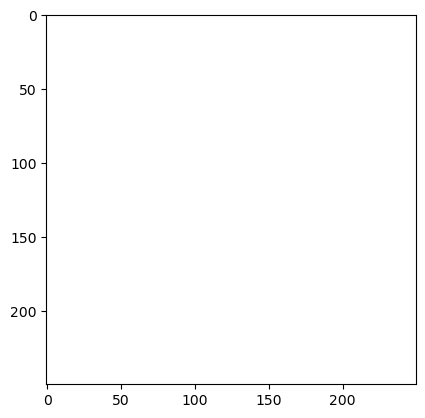

In [31]:
##### Generate empty image and populate with 2 rectangles


buf_image =cv2.resize(image_1, (250, 250), # make all pictures standard
                                 interpolation = cv2.INTER_AREA)

buf_image[:,:,:] = 255
ssresults_buf = ssresults1[:2]
plt.imshow(buf_image)

In [33]:
#### Set coordinates for 2 proposals, intersected

ssresults_buf[0] = np.array( [90,20,60,100] ) # x, y, x+w, y+h
ssresults_buf[1] = np.array( [100,92,30,40] )
ssresults_buf


array([[ 90,  20,  60, 100],
       [100,  92,  30,  40]])

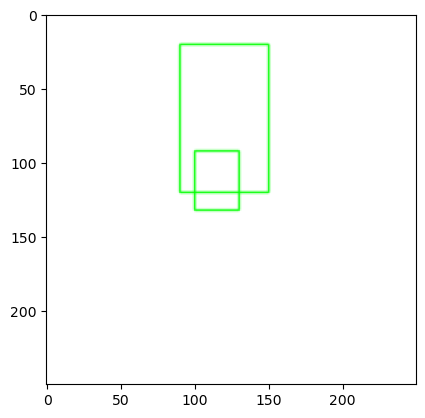

In [34]:
# visualise proposals
imout = buf_image.copy()
box_apples = [] # coordinates of proposals of apples
box_area = [] # area of rectangle with apple
for count ,result in enumerate(ssresults_buf): 
                x,y,w,h = result
                box_apples.append( list(result)  )
                box_area.append( w*h )
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                
plt.figure()
plt.imshow(imout)

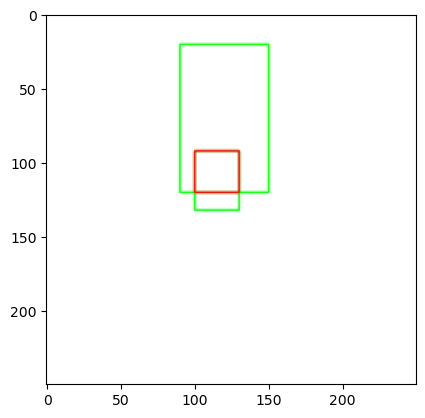

In [35]:
## Estimate coordinates of intersection area
# https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

x_left = max( ssresults_buf[0][0], ssresults_buf[1][0] ) # x1 , x2
x_right = min( ssresults_buf[0][0] + ssresults_buf[0][2], ssresults_buf[1][0] + ssresults_buf[1][2] ) #  x1+w1 , x2+w2

y_top = max( ssresults_buf[0][1], ssresults_buf[1][1] ) # y1,y2
y_bottom = min( ssresults_buf[0][1] + ssresults_buf[0][3], ssresults_buf[1][1]+ssresults_buf[1][3] ) # y1+h1 , y2+h2

cv2.rectangle(imout, (x_left, y_bottom), (x_right, y_top), (255, 0, 0), 1, cv2.LINE_AA) # (x,y) , (x+w, y+)
plt.imshow(imout)

In [36]:
### Intersection height and width
[ np.maximum(y_bottom -  y_top  + 1 , 0),  np.maximum(x_right - x_left + 1,0)  ]

i_height = np.maximum(y_bottom -  y_top  + 1 , 0)
i_width = np.maximum(x_right - x_left + 1,0)
[i_height , i_width,  i_height*i_width ]

[29, 31, 899]

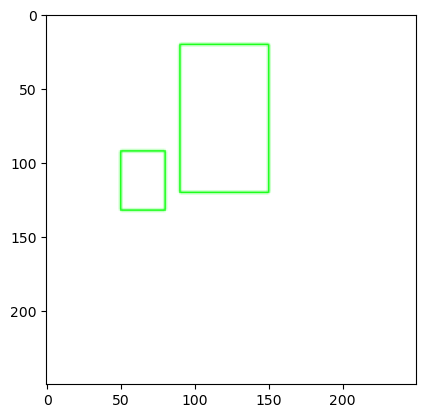

In [37]:
#### Set coordinates for 2 proposals, non intersected

ssresults_buf[0] = np.array( [90,20,60,100] ) # x, y, x+w, y+h
ssresults_buf[1] = np.array( [50,92,30,40] )
ssresults_buf

imout = buf_image.copy()
box_apples = [] # coordinates of proposals of apples
box_area = [] # area of rectangle with apple
for count ,result in enumerate(ssresults_buf): 
                x,y,w,h = result
                box_apples.append( list(result)  )
                box_area.append( w*h )
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                
plt.figure()
plt.imshow(imout)

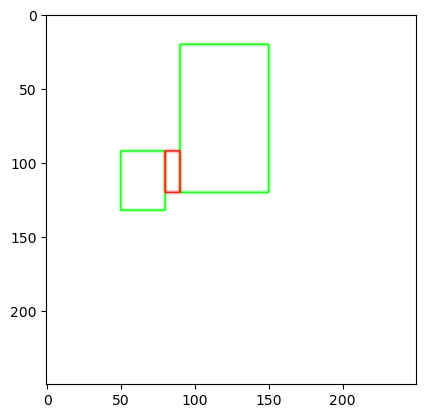

In [38]:
x_left = max( ssresults_buf[0][0], ssresults_buf[1][0] ) # x1 , x2
x_right = min( ssresults_buf[0][0] + ssresults_buf[0][2], ssresults_buf[1][0] + ssresults_buf[1][2] ) #  x1+w1 , x2+w2

y_top = max( ssresults_buf[0][1], ssresults_buf[1][1] ) # y1,y2
y_bottom = min( ssresults_buf[0][1] + ssresults_buf[0][3], ssresults_buf[1][1]+ssresults_buf[1][3] ) # y1+h1 , y2+h2

cv2.rectangle(imout, (x_left, y_bottom), (x_right, y_top), (255, 0, 0), 1, cv2.LINE_AA) # (x,y) , (x+w, y+)
plt.imshow(imout)

In [39]:
### Intersection height and width
[ np.maximum(y_bottom -  y_top  + 1 , 0),  np.maximum(x_right - x_left + 1,0)  ]

i_height = np.maximum(y_bottom -  y_top  + 1 , 0)
i_width = np.maximum(x_right - x_left + 1,0)
[i_height , i_width, i_height*i_width ]

[29, 0, 0]

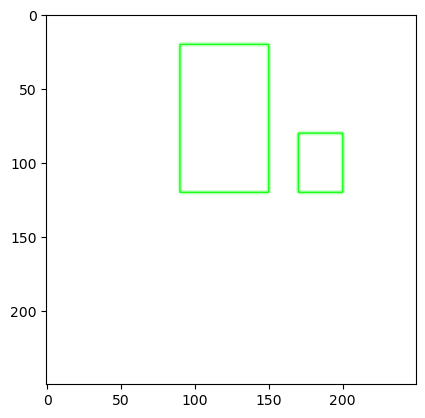

In [40]:
#### Set coordinates for 2 proposals, non intersected

ssresults_buf[0] = np.array( [90,20,60,100] ) # x, y, x+w, y+h
ssresults_buf[1] = np.array( [170,80,30,40] )
ssresults_buf

imout = buf_image.copy()
box_apples = [] # coordinates of proposals of apples
box_area = [] # area of rectangle with apple
for count ,result in enumerate(ssresults_buf): 
                x,y,w,h = result
                box_apples.append( list(result)  )
                box_area.append( w*h )
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                
plt.figure()
plt.imshow(imout)

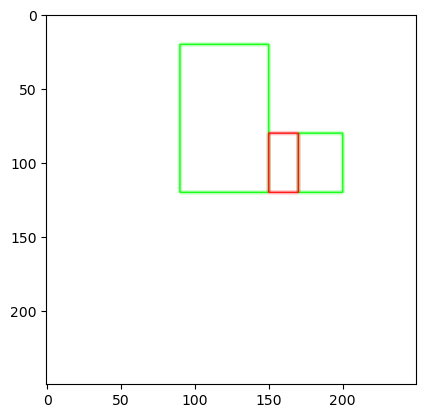

In [41]:
x_left = max( ssresults_buf[0][0], ssresults_buf[1][0] ) # x1 , x2
x_right = min( ssresults_buf[0][0] + ssresults_buf[0][2], ssresults_buf[1][0] + ssresults_buf[1][2] ) #  x1+w1 , x2+w2

y_top = max( ssresults_buf[0][1], ssresults_buf[1][1] ) # y1,y2
y_bottom = min( ssresults_buf[0][1] + ssresults_buf[0][3], ssresults_buf[1][1]+ssresults_buf[1][3] ) # y1+h1 , y2+h2

cv2.rectangle(imout, (x_left, y_bottom), (x_right, y_top), (255, 0, 0), 1, cv2.LINE_AA) # (x,y) , (x+w, y+)
plt.imshow(imout)

In [42]:
### Intersection height and width
[ np.maximum(y_bottom -  y_top  + 1 , 0),  np.maximum(x_right - x_left + 1,0)  ]

i_height = np.maximum(y_bottom -  y_top  + 1 , 0)
i_width = np.maximum(x_right - x_left + 1,0)
[i_height , i_width, i_height * i_width ]

[41, 0, 0]

#### Non-maximum Suppression (NMS) Demo
#### over single image

In [139]:
# function  to predict with CNN if proposals generated
# by generate_proposals() has 0 or 1-st class

def predict_proposal_iou( x , model , rects  , lower_lim = 0, upper_lim=0.2, reacts_lim = 2500 ):
   
    imout = x.copy() # reset image to clean it from rectangles
    gray = cv2.cvtColor(imout, cv2.COLOR_BGR2GRAY) 
    box_target_fnc = [] # store coordinates of proposals which can contain apple
    box_area_fnc=[]  # store areas of proposals which contain apples
    
    for count ,result in enumerate(rects): 
        if count <= reacts_lim:
                x,y,w,h = result
                timage = gray[y:y+h,x:x+w] # this is sub pic, proposal, rect cut from main image
                resized = cv2.resize(timage, ( IMG_WIDTH,IMG_HEIGHT ), interpolation = cv2.INTER_AREA)
                resized = np.array( resized, dtype = "float16" )
                resized /= 255 
                img = np.expand_dims(resized, axis=0)
                
                out= model.predict(img, verbose = 0) # verbose of 1 will produce message for each proposal, not convenient
                
                if out[0][0] >= lower_lim and out[0][0] <= upper_lim : # based on probability we define if 1 or 0 is predicted class
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    box_target_fnc.append( list(result) )
                    box_area_fnc.append( w*h ) # area of proposal
                    
    return imout  ,   box_target_fnc ,  box_area_fnc


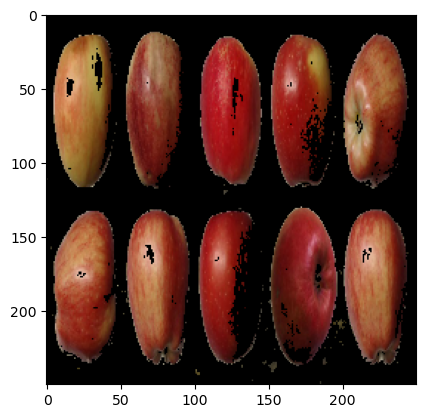

In [140]:
plt.imshow( image_1_blackened )

In [141]:
##### prediction with coordinates and areas

plot_proposals, box_target, box_area =  predict_proposal_iou( image_1_blackened , model=model_v0_cnn_binary  , rects = ssresults1 , lower_lim = 0.5, upper_lim=1, reacts_lim = 2000 )


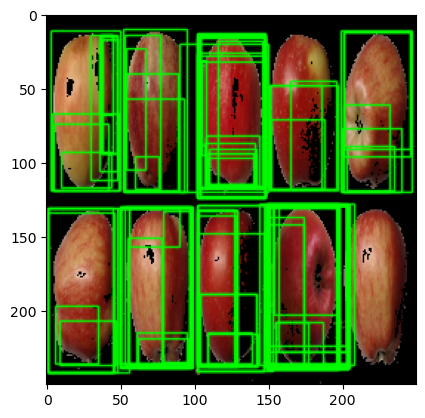

In [142]:
plt.imshow( plot_proposals )

In [143]:
box_target[1:5]

[[56, 131, 34, 26], [50, 130, 49, 109], [3, 11, 47, 108], [102, 129, 45, 112]]

In [144]:
box_area[1:5]

[884, 5341, 5076, 5040]

In [327]:
9*54

486

In [145]:
#### apply quantiles to remove outliers
q_low,q_top = np.quantile( box_area, [0.1,0.9] )
[q_low , q_top]

[730.4000000000001, 5687.400000000001]

In [146]:
#### locations of area values outside quantiles
loc=[]
for i in range( 0, len(box_area)  ):
    if box_area[i]<q_low or box_area[i]>q_top :
       loc.append( i )
    
[ len ( loc ) , len(box_area) , len(box_target) ]


[20, 97, 97]

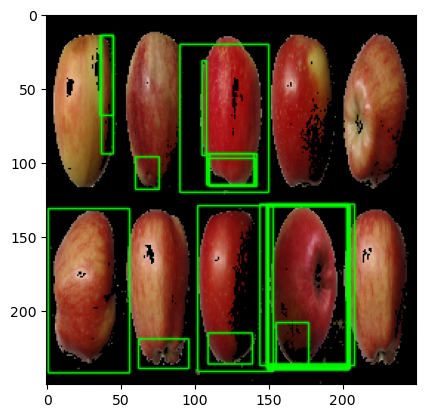

In [147]:
##  areas outside quantiles

buf_rectangles = [box_target[i] for i in loc] ## select proposals coordinates with area outside quantiles

imout = image_1_blackened.copy()

for count ,result in enumerate(buf_rectangles): 
                x,y,w,h = result
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                     # code above draws rectangles on main picture
plt.figure()
plt.imshow(imout)

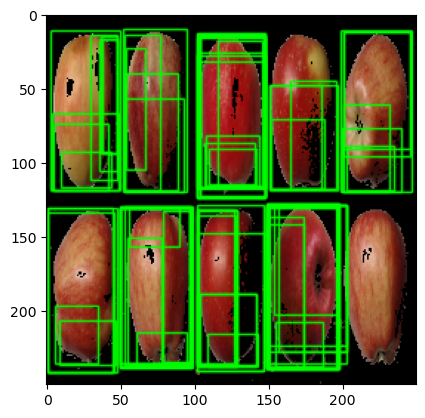

In [148]:
# areas inside quantiles
loc=[]
for i in range( 0, len(box_area)  ):
    if box_area[i]>=q_low and box_area[i]<=q_top : # instead of "or"
       loc.append( i )
    
buf_rectangles = [box_target[i] for i in loc]

imout = image_1_blackened.copy()

for count ,result in enumerate(buf_rectangles): 
                x,y,w,h = result
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                     # code above draws rectangles on main picture
plt.figure()
plt.imshow(imout)

In [149]:
[ len(loc) ,  len(box_target)  , len(box_area)  ] # 49 - 6 = 43 , 6 are outside quantiles

[77, 97, 97]

In [150]:
#### Select coordinates and data inside quantiles

box_target_2 = [box_target[i] for i in loc]
box_area_2 = [box_area[i] for i in loc]

[ len(box_target_2)  , len(box_area_2)  ]

[77, 77]

In [119]:
#### We need to sort both list with coordinates and area
#### from rectangl from largest to smallest area

In [58]:
box_area_2[1:5]

[5341, 5076, 5040, 5136]

In [59]:
box_target_2[1:5]

[[50, 130, 49, 109], [3, 11, 47, 108], [102, 129, 45, 112], [50, 131, 48, 107]]

In [60]:
47*108

5076

In [151]:
# https://www.geeksforgeeks.org/python-sort-list-according-second-element-sublist/

def Sort(list_1 , list_2):
   
    l = len(list_1)
     
    for i in range(0, l):
        for j in range(0, l-i-1):
             
            if (list_1[j] < list_1[j + 1]):
                
                tempo = list_1[j]
                list_1[j] = list_1[j + 1]
                list_1[j + 1] = tempo
                
                tempo = list_2[j]
                list_2[j] = list_2[j + 1]
                list_2[j + 1] = tempo
     
    return list_1 ,list_2
 
box_area_2_sorted , box_target_2_sorted = Sort(box_area_2 , box_target_2)  

print(  Sort(box_area_2_sorted , box_target_2_sorted)  )


([5671, 5488, 5439, 5341, 5280, 5247, 5232, 5232, 5217, 5184, 5170, 5170, 5136, 5130, 5106, 5076, 5060, 5040, 5040, 5029, 4968, 4935, 4884, 4860, 4830, 4815, 4752, 4730, 4554, 4532, 4532, 4508, 4488, 4416, 4185, 4004, 3780, 3555, 3266, 3182, 2940, 2862, 2844, 2730, 2626, 2600, 2550, 2520, 2520, 2450, 2425, 2340, 2263, 1955, 1920, 1862, 1836, 1829, 1764, 1720, 1692, 1665, 1224, 1140, 1131, 1068, 1066, 986, 960, 960, 884, 869, 816, 782, 770, 768, 748], [[150, 129, 53, 107], [149, 128, 49, 112], [149, 128, 49, 111], [50, 130, 49, 109], [149, 129, 48, 110], [150, 129, 53, 99], [199, 11, 48, 109], [50, 130, 48, 109], [1, 131, 47, 111], [149, 131, 48, 108], [149, 129, 47, 110], [150, 129, 47, 110], [50, 131, 48, 107], [149, 129, 54, 95], [102, 13, 46, 111], [3, 11, 47, 108], [151, 130, 46, 110], [102, 129, 45, 112], [50, 131, 48, 105], [50, 131, 47, 107], [102, 16, 46, 108], [50, 131, 47, 105], [1, 131, 44, 111], [1, 134, 45, 108], [102, 13, 46, 105], [53, 130, 45, 107], [104, 15, 44, 108], 

In [152]:
##### debug function , all must be True
buf = []
for i in range(0, len(box_area_2_sorted) ):
    buf.append( box_area_2_sorted[i] == box_target_2_sorted[i][2] * box_target_2_sorted[i][3]  )
buf 

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [157]:
### Unite Non Max and IoU voa Loop, not finished
box_area_loop = box_area_2_sorted.copy() 
box_target_loop = box_target_2_sorted.copy()

ct = 0
i = 0
while  ct==0:    
       
        ## we select largest rectanle in the beginning
        cand_area = box_area_loop[i]
        cand_coor = box_target_loop[i]
        loc_remove = []
        
        # because list is sorted , all rectangles after index i would be smaller
        for j in range( i+1 , len( box_area_loop ) ):
                     
              ## calculate Area of intersection rectangle
            x_left = max( cand_coor[0], box_target_loop[j][0] ) # x1 , x2
            x_right = min( cand_coor[0] + cand_coor[2], box_target_loop[j][0] + box_target_loop[j][2] ) #  x1+w1 , x2+w2
            y_top = max( cand_coor[1], box_target_loop[j][1] ) # y1,y2
            y_bottom = min( cand_coor[1] + cand_coor[3], box_target_loop[j][1]+box_target_loop[j][3] ) # y1+h1 , y2+h2            
            i_height = np.maximum(y_bottom -  y_top  + 1 , 0)
            i_width = np.maximum(x_right - x_left + 1,0)
            
            area_of_intersection = i_height * i_width       
            
            if area_of_intersection>0: # if intersection exists
                
                # debug section , visualize intersection               
                buf_image =cv2.resize(image_1, (250, 250), interpolation = cv2.INTER_AREA)
                buf_image[:,:,:] = 255             
                cv2.rectangle(buf_image, (cand_coor[0], cand_coor[1]), (cand_coor[0] + cand_coor[2], cand_coor[1] + cand_coor[3]), (0, 255, 0), 1, cv2.LINE_AA)  
                cv2.rectangle(buf_image, (box_target_loop[j][0], box_target_loop[j][1]), (box_target_loop[j][0] + box_target_loop[j][2], box_target_loop[j][1] + box_target_loop[j][3]), (0, 0, 255), 1, cv2.LINE_AA)                
                cv2.rectangle(buf_image, (x_left, y_bottom), (x_right, y_top), (255, 0, 0), 1, cv2.LINE_AA) # (x,y) , (x+w, y+)
                             
                area_of_union = cand_area + box_area_loop[j]  # iou = area_of_intersection / (area_of_union  )
                iou = area_of_intersection / (box_area_loop[j] ) #  intersection area divided by smaller rectangle
             #   plt.figure()
             #   print( [area_of_intersection, cand_area, box_area_loop[j], iou ] )
             #   print(  plt.imshow(buf_image) )
              #  ct=1
              #  break
                
                if iou>0.8: 
                    loc_remove.append( j ) ### indices of values to remove because they represent parts of larger box
                  #  print( [ "delete candidate", len(loc_remove) ])
                    
        if len( loc_remove )>0: # delete proposales which are parts of larger rectangle
            for del_index in loc_remove: # we decrease length of loop but indices remain the same, replace del with string
               # print( [del_index ,len(loc_remove) ,  len(box_area_loop) , len(box_target_loop)] )
                 box_area_loop[del_index] = "remove"
                 box_target_loop[del_index] = "remove"
                    
            box_area_loop = [ x  for x in box_area_loop if x!="remove" ] 
            box_target_loop = [ x  for x in box_target_loop  if x!="remove"] 
        
        i+=1    # move to next candidate    
        
        try: 
            box_area_loop[i+1]
        except IndexError:
            ct=1
        

In [158]:
##### debug function , all must be True, also if all True, it shows count of apples
buf = []
for i in range(0, len(box_area_loop) ):
    buf.append( box_area_loop[i] == box_target_loop[i][2] * box_target_loop[i][3]  )
buf 


[True, True, True, True, True, True, True, True, True]

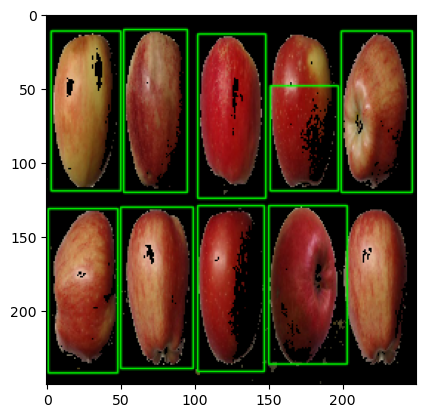

In [159]:
imout = image_1_blackened.copy()

for count ,result in enumerate(box_target_loop): 
                x,y,w,h = result
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                     # code above draws rectangles on main picture
plt.figure()
plt.imshow(imout)